In [2]:
%matplotlib inline

##Import Data

In [3]:
import epi_prediction
src_dir = '/Users/johnbonihalab/data/chuyu/modalities'
control_filter = lambda file_name: 'CON' in file_name
patient_filter = lambda file_name: 'PAT' in file_name

In [4]:
epi_paths = epi_prediction.get_epi_paths(src_dir, patient_filter, control_filter)


In [5]:
mod_paths = epi_paths['dmean']

In [6]:
mod_paths

cons    [/Users/johnbonihalab/data/chuyu/modalities/dm...
pats    [/Users/johnbonihalab/data/chuyu/modalities/dm...
Name: dmean, dtype: object

In [7]:
labels = len(mod_paths['pats']) * [1] + len(mod_paths['cons']) * [0]

In [8]:
len(labels)

68

##Load White Matter Mask

In [9]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', threshold=.2)

In [10]:
mat = white_matter.transform_many(mod_paths['pats'] + mod_paths['cons'], verbose=True)

--------------------------------------------------------------------
####################################################################

##Retrieve the Voxels

__Retrieving Important Voxels Requires Linear Classifier__

In [12]:
from nilearn.input_data import NiftiMasker
import numpy as np
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [13]:
n_folds = 6
svc = SVC()
anova_svc_lin = Pipeline( [('anova', SelectKBest(k=500)), ('svc', svc)] )
anova_svc_lin.set_params(svc__kernel='linear')
cv = StratifiedKFold(labels, n_folds=6)
labels_arr = np.array(labels)

In [14]:
C_range_lin = np.logspace(-3, 3, 7)
#k_range = np.linspace(500,2000,3).astype(int)
k_range=[500]

total_runs = len(C_range_lin) * 2 * len(k_range) * 2

scorer = epi_prediction.verbose_scorer(total_runs)
grid_lin = GridSearchCV(anova_svc_lin, param_grid={"svc__C": C_range_lin,"anova__k" :k_range}, cv=cv, scoring = scorer)

grid_lin.fit(mat, labels_arr)

----------------------------
##########################################

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x109e1f668>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'anova__k': [500], 'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(verbose_score_fn), verbose=0)

In [15]:
grid_lin.grid_scores_

[mean: 0.58889, std: 0.19303, params: {'anova__k': 500, 'svc__C': 0.001},
 mean: 0.69020, std: 0.13056, params: {'anova__k': 500, 'svc__C': 0.01},
 mean: 0.69265, std: 0.14039, params: {'anova__k': 500, 'svc__C': 0.10000000000000001},
 mean: 0.64751, std: 0.12043, params: {'anova__k': 500, 'svc__C': 1.0},
 mean: 0.64751, std: 0.12043, params: {'anova__k': 500, 'svc__C': 10.0},
 mean: 0.64751, std: 0.12043, params: {'anova__k': 500, 'svc__C': 100.0},
 mean: 0.64751, std: 0.12043, params: {'anova__k': 500, 'svc__C': 1000.0}]

In [16]:
anova_svc_lin.set_params(svc__C=.1, anova__k=500) #best k is using 2000, but pre C of C was 500

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x109e1f668>)), ('svc', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [17]:
svc = anova_svc_lin.named_steps['svc']
anova = anova_svc_lin.named_steps['anova']

In [28]:
reload(epi_prediction)
def fit(train):
    anova_svc_lin.fit(mat[train], labels_arr[train])

def coeffs_fn(filter_fn):
    def fn():
        svc_coef = svc.coef_.copy()
        svc_coef[filter_fn(svc.coef_) == 0] = 0
        return white_matter.inv_transform(anova.inverse_transform(svc_coef))
    return fn

#neg_coeffs = epi_prediction.calc_coeffs(cv, fit, coeffs_fn(lambda c: c < 0))
#pos_coeffs = epi_prediction.calc_coeffs(cv, fit, coeffs_fn(lambda c: c > 0))

coeffs = epi_prediction.calc_coeffs(cv, fit, coeffs_fn(lambda c: c))

In [23]:
coeffs.shape

(91, 109, 91)

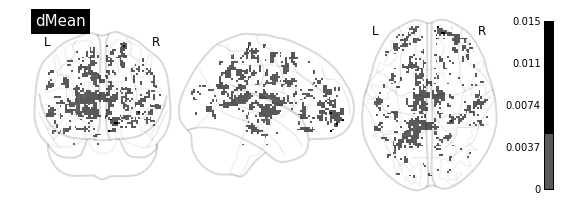

In [24]:
reload(epi_prediction)

import IPython
from IPython.html.widgets import interact, interactive
from IPython.html.widgets.widget_float import FloatSlider

title='dMean'
def plot_bw(base_b):
    epi_prediction.plot_bw_coeffs(coeffs, white_matter._mask_image.get_affine(), title,
                                 base_brightness=base_b)

base_b_slider = FloatSlider(min=0, max=1, step=0.1, value=.7)
w=interactive(plot_bw,base_b=base_b_slider)
IPython.display.display(w)

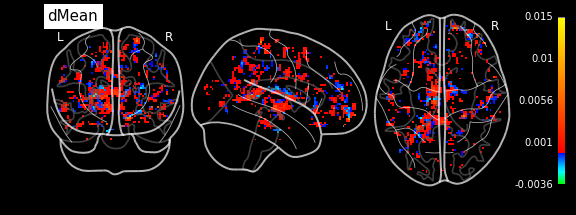

In [29]:
reload(epi_prediction)

def save_and_plot(save, **kwargs):
    affine = white_matter._mask_image.get_affine()
    kwargs['title'] = title
    epi_prediction.plot_coeffs(coeffs, affine, **kwargs)

    if save:
        output_file = title+'_color'
        print "about to save " + output_file
        kwargs['output_file'] = output_file
        epi_prediction.plot_coeffs(coeffs, affine, **kwargs)
        print "saved " + output_file

nd_slider = FloatSlider(min=0, max=1, step=0.1, value=.7)
pd_slider = FloatSlider(min=0, max=1, step=0.1, value=.7)
w=interactive(save_and_plot, save=False, neg_disp=nd_slider, pos_disp=pd_slider, 
              plot_abs=False, colorbar=True, black_bg=True, symmetric_cbar=False)
IPython.display.display(w)

##Generate Linear Confusion Matrix

In [22]:
cv_info_lin, cv_info_train_lin = epi_prediction.verbose_cv(mat, labels_arr, anova_svc_lin, n_folds=6, verbose=False)

####
####
####
####
####
####


In [23]:
cv_info_lin.confusion_matrix()

array([[27,  9],
       [10, 22]])

In [24]:
cv_info_lin.normalized_confusion_matrix()

array([[ 0.75  ,  0.25  ],
       [ 0.3125,  0.6875]])

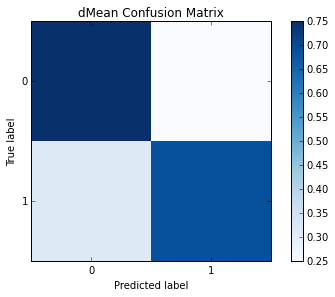

In [25]:
epi_prediction.plot_confusion_matrix(cv_info_lin.normalized_confusion_matrix(), "dMean Confusion Matrix")

In [26]:
cv_info_lin.avg_f1_score()

0.69343434343434351

In [27]:
cv_info_lin.avg_sensitivity_score()

0.69444444444444453

In [28]:
cv_info_lin.avg_specificity_score()

0.75